# _Capstone Project 1: In-Depth Analysis & Machine Learning_

### Step 1: Getting Everything Ready

In [2]:
# import initial modules
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [3]:
# import data 
# dataframe for linear/ridge/huber regression
df = pd.read_csv('data/df_all-Copy1.csv')

# dataframe for RandomForest
df_rf = pd.read_csv('data/df_all-Copy1.csv')

In [4]:
# dataframe that sets cut-off based on PER (i.e. player played more than 58 games)
df_threshold = pd.read_csv('data/df_threshold-Copy1.csv')

In [5]:
df.head(3)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Alex Abrines,SG,24,OKC,75,8,1134,5.0,12.7,0.395,3.7,9.7,0.380,1.4,3.1,0.443,1.7,2.0,0.848,1.1,3.9,5.0,1.2,1.7,0.4,1.1,5.4,15.4,116.0,110.0,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,1.3,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,2018
1,Quincy Acy,PF,27,BRK,70,8,1359,4.6,13.0,0.356,3.6,10.4,0.349,1.0,2.6,0.384,1.8,2.1,0.817,1.4,7.8,9.2,2.0,1.2,1.0,2.1,5.3,14.7,99.0,110.0,8.2,0.525,0.800,0.164,3.1,17.1,10.0,6.0,1.2,1.6,13.3,14.4,-0.1,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,2018
2,Steven Adams,C,24,OKC,76,76,2487,8.9,14.2,0.629,0.0,0.0,0.000,8.9,14.2,0.631,3.2,5.7,0.559,7.7,6.0,13.7,1.8,1.8,1.6,2.6,4.3,21.1,125.0,107.0,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.3,16.7,6.7,3.0,9.7,0.187,2.2,1.1,3.3,3.3,2018


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Data columns (total 51 columns):
Player    4759 non-null object
Pos       4759 non-null object
Age       4759 non-null int64
Tm        4759 non-null object
G         4759 non-null int64
GS        4759 non-null int64
MP        4759 non-null int64
FG        4759 non-null float64
FGA       4759 non-null float64
FG%       4759 non-null float64
3P        4759 non-null float64
3PA       4759 non-null float64
3P%       4759 non-null float64
2P        4759 non-null float64
2PA       4759 non-null float64
2P%       4759 non-null float64
FT        4759 non-null float64
FTA       4759 non-null float64
FT%       4759 non-null float64
ORB       4759 non-null float64
DRB       4759 non-null float64
TRB       4759 non-null float64
AST       4759 non-null float64
STL       4759 non-null float64
BLK       4759 non-null float64
TOV       4759 non-null float64
PF        4759 non-null float64
PTS       4759 non-null float64
ORtg    

In [7]:
# change position, team, and year columns to categorical variables
df[['Pos', 'Tm', 'Year']] = df[['Pos', 'Tm', 'Year']].astype('category')
df_rf[['Pos', 'Tm', 'Year']] = df_rf[['Pos', 'Tm', 'Year']].astype('category')
df_threshold[['Pos', 'Tm', 'Year']] = df_threshold[['Pos', 'Tm', 'Year']].astype('category')

In [8]:
# one-hot encode the data for random forest model using pandas get_dummies
df_rf = pd.get_dummies(df, columns = ['Pos', 'Tm', 'Year'])

In [9]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Columns: 106 entries, Player to Year_2018
dtypes: float64(43), int64(4), object(1), uint8(58)
memory usage: 2.0+ MB


In [10]:
# create function that creates array of features and target variable, and returns list of features
# if data set for random forest model, it will only drop Player and WS/48 columns
def convert_features(df, random_forest=True):
    # labels are the values we want to predict
    y = np.array(df['WS/48'])
    
    # remove the labels from the features
    # axis 1 refers to the columns
    if random_forest == True:
        X = df.drop(['Player','WS/48'], axis = 1)
    else:
        X = df.drop(['Player', 'Pos', 'Age', 'Tm', 'OWS', 'DWS', 'WS', 'WS/48', 'Year'], axis = 1)
    
    # saving feature names for later use
    feature_list = list(X.columns)
    
    # convert to np array
    X = np.array(X)
    
    print(X.shape)
    print(y.shape)
    
    return X, y, feature_list

In [11]:
# scale the data to be between -1 and 1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# function that scales the data and then splits it into train and test set
def scale_then_split(X, y, split=True):
    
    # scale the feature data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
        
    # print shape of train and test data sets
    print('Training Features Shape:', X_train.shape)
    print('Training Label Shape:', y_train.shape)
    print('Testing Features Shape:', X_test.shape)
    print('Testing Labels Shape:', y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [12]:
# create evaluate function that returns model performance as expressed as RMSE and R^2 score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('Root Mean Squared Error: {:0.4f}'.format(rmse))
    print('R^2 Score = {:0.4f}'.format(r2))
    
    return predictions, rmse, r2

## _Linear Regression: An Overview_

For this project we are trying to determine a player's `WS/48`, i.e., how many 'wins' he contributes for every 48 minutes he plays. While statistics like total points, rebounds and assists are all vital statistics when evaluating any given player, but there is something that trumps all other statistics in basketball (and pretty much all sports): winning. 

The statistics mentioned above only describe a particular segment of that player's contribution to his team whereas `WS/48` (win shares per 48 minutes) attempts to combine all these into one statistic. I'm going to admit up front that it is not perfect. However, it's like the saying: "All models are wrong, but some are useful." In this case, `WS/48` is a useful 'model' in bringing together players offensive and defensive statistics into a single number that allows us to see his level of contribution towards a team winning. 

Now I want to recap what we've done so far up to this point for this project.

1. Pulled Per Possession and Advanced statistics from [basketball-reference.com](https://www.basketball-reference.com/) for the past ten seasons (__not including the 2018-2019 season__)
2. Cleaned up raw data into a usable format
3. Performed Exploratory Data Analysis of features of the clean data set

Now we are on the fourth and final step: use machine learning to create a model that can approximately predict a player's `WS/48` statistic. 

How are we going to do this? Two words: linear regression. That's where we'll begin, with `sklearn`'s `LinearRegression` algorithm. 

Linear regression attempts to model the relationship between a dependent variable and one or more independent variables. If you are using one independent variable, i.e., a one-to-one relationship between the independent and dependent variable, it is called `simple linear regression.` You are not limited to just one though; you can use more than one independent variable, which is called `multiple linear regression.` In summary:

- Simple = 1 independent variable
- Multiple = 2+ independent variables

Now without further ado, let's dive in!

In [13]:
# create array of features and target variable for regression model
X, y, features = convert_features(df, random_forest=False)

(4759, 42)
(4759,)


In [14]:
# scale then split data
X_train, X_test, y_train, y_test = scale_then_split(X, y)

Training Features Shape: (3331, 42)
Training Label Shape: (3331,)
Testing Features Shape: (1428, 42)
Testing Labels Shape: (1428,)


In [15]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: lr
lr = LinearRegression()

# Fit the model to the data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
from sklearn.metrics import mean_squared_error

# Predict on the hold out set and compute metrics
y_pred = lr.predict(X_test)
r2 = lr.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [17]:
print("Linear Regression R squared: {}".format(r2))
print("Linear Regression RMSE: {}".format(rmse))

Linear Regression R squared: 0.9750975020909806
Linear Regression RMSE: 0.017308202201025726


In [18]:
evaluate(lr, X_test, y_test);

Model Performance
Root Mean Squared Error: 0.0173
R^2 Score = 0.9751


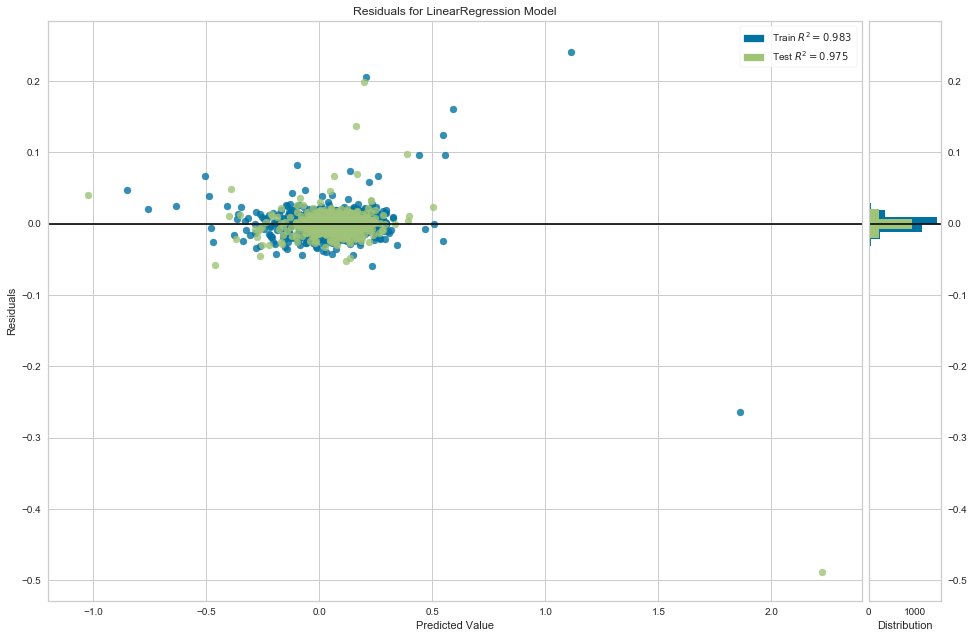

In [19]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();                # Draw/show/poof the data

# _ASSESSMENT: MULTIPLE LINEAR REGRESSION_

The performance of the model looks pretty amazing! The first statistic, the R squared, basically indicates how close the data is to the fitted regression line. The scale for this number is between 0 and 1.0, 0 indicating that the model does not explain any of the variability of the response variable (it would basically just be a random assortment of points) and 1 indicating a 'perfect' model in that the model explains all of the variability of the response variable. With our R^2 statistic being ~0.96, this model looks nearly perfect! 

Next, we'll take a look at the RMSE, or root mean square error. This metric also indicates how close the observed data points are to the model's predicted values and is extremely useful in that it presents results in the same units as the response variable, i.e. `WS/48`. Here our RMSE is ~0.0177 telling us that on average our predictions were this far off from the observed value.

Lastly, let's look at the residual plot. For the most part, it looks good; the residuals (i.e., the difference in the predicted value and observed value) are not systematically high or low and approximately centered on zero. Also, the histograms to the right look roughly normally distributed, which is a fundamental assumption of residuals in OLS regression. There appear to be a few outliers, mainly two that severely underestimated `WS/48` which is somewhat concerning and worth looking into further. Overall though, this is an impressive start. 

It looks like we got ourselves a model then, right? __WRONG__. 

However, before I go further I want to create the same model as before but this time with the `statsmodels` module, which is way better than `sklearn` in regards to statistical data exploration and tests.

In [20]:
import statsmodels.api as sm

X_stats = X # convert to numpy array
X_stats = sm.add_constant(X) # with statsmodels an intercept is not included by default so we need to add one

model = sm.OLS(y, X).fit() # fit ordinary least squares model 
predictions = model.predict(X) # predict values from fitted model

print_model = model.summary() 
print(print_model) # return a summary of the regression results

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9884.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        13:54:18   Log-Likelihood:                 13826.
No. Observations:                4759   AIC:                        -2.757e+04
Df Residuals:                    4717   BIC:                        -2.730e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.037e-05   2.11e-05      4.288      0.0

# _Interpretation of `statsmodels` result_ 

Using the same features as the model we created with `sklearn,` we were able to develop a model that had an R squared of 0.989, which was slightly better (albeit we did not split the data into train/test sets, a big no-no). 

However, when we scroll to the bottom, we see under `Warnings` a message talking about a condition number being large, indicating the possibility of strong multicollinearity. What does this mean? 

While I won't go too deeply into exactly what the condition number is (as it is a little above my mental pay-grade and involves the use of matrices and derivatives) but from a high level, it is a measure of how sensitive a function is to changes or errors in the input. For linear regression, it's a diagnostic for multicollinearity.

Now, this model has a high condition number which indicates multicollinearity, but what exactly does multicollinearity mean? 

Collinearity means there is an association between _two_ explanatory (independent) variables, which means that two of the features we're using have a relationship with each other. Now, multicollinearity is when two or more explanatory variables (i.e., features) in a multiple regression model are highly linearly related. [1](https://en.wikipedia.org/wiki/Multicollinearity)

Going back to our `statsmodels` example, we can see from the features that this makes total sense. A quick example is in regards to `G` (games played) and `GS` (games started); if a player plays in more games, there is probably going to be a greater likelihood that he is going to have started in more games. In other words, these two variables have a relationship! Another example would be in all the shooting percentages -- `FG%,` `3P%`, `2P%`, `FT%` -- as they all depend on the number of makes and attempts which are also in the feature set! 

Hopefully, you can see a trend with regards to our feature set and multicollinearity. With basketball statistics and the relatedness that a lot of them have with each other, I wasn't surprised when this happened. 

Additionally, let's take a look at the `P>|t|` column above. This column represents the `p-values` that tests the null hypothesis that the coefficient of that particular variable (i.e., feature) does not affect the relationship. Generally, a general rule-of-thumb is to use a threshold of 0.05, with a number below this meaning we reject the null hypothesis of no effect. Instead, we favor the alternative hypothesis which is that this coefficient does have an impact on the response. 

What is slightly confusing, however, is that there are some variables, like `FG` and `PTS,` that indicated a pretty significant relationship during our exploratory data analysis (via scatter plots) but have high p-values (i.e., we cannot reject the null hypothesis that they have no effect). I hypothesize that the high complexity (i.e., high # of total features) of the model is leading to 'noise' crowding out the relationship. 

At this point we've poked quite a few holes in this model but where do we go from here?

The logical next step would seem to point towards feature selection, which is a fundamental concept in machine learning and involves selecting the most relevant variables for use in predicting the response variable, which in our case is `WS/48`. 

Now we could begin by doing something along the lines of examing R-squared values of each of the variables and `WS/48`, then use a subset of variables to create a model. However, this can be tedious, and there is no guarantee that we won't reencounter multicollinearity. 

Which is what brings me to a new concept, called regularization but first we must discuss that bias-variance tradeoff.

(__PS__ - Below is a profile report that I generated via the `pandas-profiling` [library](https://github.com/pandas-profiling/pandas-profiling), which provides a wealth of information regarding each column. It will be presented in an interactive HTML report and also indicates where some variables are correlated with each other.)

In [21]:
# generate HTML report file via pandas-profiling of data set
import pandas_profiling

profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile='NBA_stats_profile.html')

First I want to begin by showing a (relatively) simple chart:
    
![Model Complexity](pictures/model_complexity.png)

### What is this showing us?

The graph above is a visual representation of the bias-variance tradeoff. 

Bias is associated with the features of the model, in that the more features you include, the less likely you are to miss the relevant relations between the features and response variable. For the most part, the more features you add, the better you can capture the relationship and the less 'biased' the model becomes.

Variance has to do with sensitivity to 'noise,' which are random disturbances in the data. Overfitting can happen when an algorithm begins to model this random noise versus the features we input into it. 

As you can see the more complex we make a model, we decrease the bias which is a good thing. However, there is a tradeoff, and that is we can begin to increase the variance exponentially, which is not a good thing. This increase in variance is what has happened in our first models; we've made two models that have low bias but high variance. 

Some may be wondering though, why is this whole bias-variance tradeoff a big deal? It has to do with generalizing to unseen data.

When we gather data, we are usually collecting a sample from the whole population. For example, we have gathered data from the past 10 NBA seasons yet the NBA's inaugural season was in 1946! So out of approximately 72 seasons, we have data for only 10 of those. What we are hoping for though is to create a model with this sample that we could also use on data from the 1977 season as well, and would still do a good job. In other words, we want to be able to generalize it which means we are can confidently apply it to any NBA season (given we have the statistics from that particular season). 

At this point, I would not feel comfortable doing that. There might be specific patterns or 'noise' within this particular dataset that the model is including and if we were to test it on a new data set (which doesn't have this specific noise), it would probably fail. Moreover, why would you want to make a model that performs well in for only a particular context?

Knowing this we want to decrease the bias (i.e., model complexity) of our model in hopes that we can also reduce the variance and in turn minimize the total error. 

### Lasso or Ridge? 

What we want to do is address the issue of overfitting and regularization is one way to do this. It does this by adding penalties to the original OLS equation, as the model complexity increases. 

The two examples we'll look at -- Lasso and Ridge -- add the penalty in slightly different ways.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds a penalty equivalent to the absolute value of the magnitude of the coefficients. Now, what does the presence of a significant coefficient mean? 

It means that that particular feature is a good predictor for the outcome. However, when it becomes too large, the algorithm will begin to model the intricate relations (i.e., the 'noise') which causes overfitting. 

Lasso, also known as L1 regularization, enforces a penalty on these coefficients, with weights of specific coefficients forced to zero. What this particular algorithm does is perform variable selection, with the variables that are relevant having non-zero weights. However, we need to be careful because these variables are not always the most important. For example, say some variables display collinearity between each other, Lasso will choose one based on its performance in that particular data set. If you feed it another data set, it could very well select the other variable. 

Because of this, Lasso is a useful tool for feature selection, but in regards to building a model, it may not be the best choice which is why we'll look at Ridge Regression.

While Lasso performs L1 regularization, Ridge regression performs L2 regularization which is slightly different. Instead of a penalty utilizing the absolute value, L2 takes the sum of the squared values of the coefficients multiplied by some alpha, which is a hyperparameter in the model. 

__Equations below are the cost functions of `Lasso` and `Ridge` algorithms__

_Lasso is on top and Ridge is on the bottom_
![Lasso v. Ridge Regression Objectives](pictures/ridge_lasso_regression.png)

The parameter alpha (α) can take a value from 0 to essentially infinity, and its value will have different effects on the model. The closer to 0 alpha is, the closer we get to simple linear regression (i.e., less of a penalty on the coefficients); the higher the value of alpha gets though, the closer the coefficients will get to zero meaning the model isn't modeling anything! So we'll need to optimize this when we create our ridge regression model.

Now, why is ridge regression better for this particular use case? The primary reason is that it does not eliminate any of the features. It will penalize coefficients but won't remove them. 

From a domain perspective, this is a perfect starting point for predicting an NBA player's win share. Basketball includes many different, and the better players are going to have a more well-rounded skillset (i.e., they'll be able to score plus play defense, grab rebounds, etc.). I want to try and prevent losing any of the variables because they all to some extent play a role in contributing to how 'good' a player is. However, certain parts of the game are more important in contributing to wins than others, and with ridge regression, I hope we'll be able to create a model that does that. 

# _Ridge Regression: Baseline Model_

In [22]:
# import module
from sklearn.linear_model import Ridge

In [23]:
# Create a ridge regressor: ridge
base_model = Ridge(random_state = 1)

In [24]:
# fit the model on training data
base_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [25]:
# predict on the hold out set and compute metrics
evaluate(base_model, X_test, y_test);

Model Performance
Root Mean Squared Error: 0.0181
R^2 Score = 0.9729


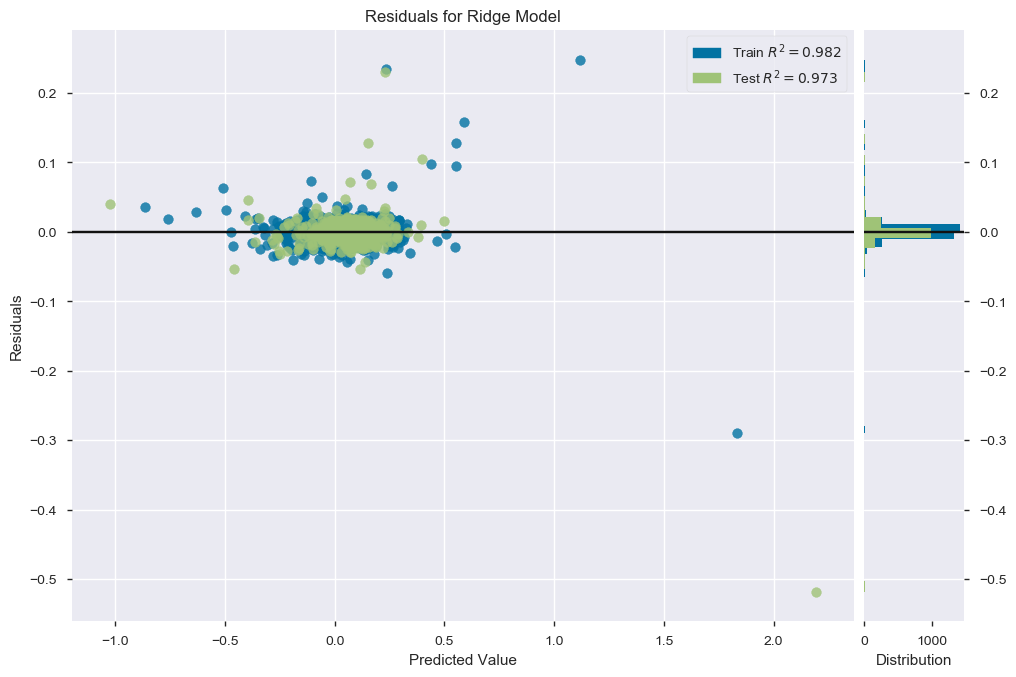

In [26]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(base_model, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

# _ASSESSMENT: RIDGE REGRESSION_

### Baseline Model

It looks like our first ridge regression model is setting the bar high! Firstly, let's walk through the steps:

1. Create the regressor by calling `Ridge` from `sklearn.linear_model` library
2. Fit the model on the training features and response variable
3. Evaluate the model on the hold out (i.e., test) data and check the RMSE and R-squared score
4. Plot residuals to check the assumption that the error terms (i.e., residuals) have an approximate mean of zero with constant variance

First, let's discuss why we split the data into training and test sets. After all why can't we use all the data to create the model, won't more data make it better?

One of the primary reasons why machine learning can be so useful is that when you create a good model, it is then able to generalize to new data and accurately predict values for it. We're now going to return to a familiar subject: overfitting. When we feed in all of our data to train a model, there is a chance that the model will fit the 'noise' associated with that specific data set. As a result, when fed new data with its own unique 'noise,' that's different from the 'noise' associated with the original data, the predictions have a higher likelihood of being unreliable. 

With machine learning we want to avoid overfitting which is why splitting the data is a common practice. After the data is separated into a training and test set, you fit (i.e., train) the model on the training set and then make predictions on the test set, which the model has not seen. Then you compare those predictions with the known labels and assess how accurate the model was. 

As you can see above, we fit the model on `X_train` and `y_train`, the training features and their associated response (i.e. `WS/48`). Next, we then inputted that trained model to the `evaluate` function. This function takes as input the `X_test` data, predicts `WS/48` for each observation in the feature test set, then compares it to the actual label in the `y_test` set. 

As output, it returns the RMSE and R-squared value. RMSE stands for 'root mean square error' and is represented by the following equation:

![RMSE Equation](pictures/rmse_equation.png)

Without getting too technical, the RMSE represents a measure of the spread of the residuals (i.e., the difference between the predicted value and the actual value) and relays how concentrated the data is around the line of best fit. We want this value to be as low as possible, since the smaller it is, the closer the values are on average to this line. Additionally, it has the benefit of being expressed in the same units as the predictions so we can gain a numerical sense of how far off the predictions are. 

On the other hand, the R-squared value is not expressed in the same units but can help us better understand how well the features (i.e., the independent variables) explain the variability in the response (i.e., dependent variable). R-squared can take a value between 0 and 1, with values closer to 1 representing a model that better explains the variability of the response (i.e., dependent) variable. In summary, the higher the R-squared, the better the model fits the data. 

Lastly, one of the main assumptions of linear models is that the residuals are normally distributed, which is known as homoscedasticity (meaning "same variance"). If the residuals differ in which case, a particular pattern may be present within the distribution, than homoscedasticity is violated meaning the model may not be the best fit for that specific data. 

After review these metrics let's turn back to the model's results. Our RMSE is low, and the R-squared value is nearly 1, indicating a near perfect fit. Additionally, the residuals appear to be approximately normally distributed save for a few outliers. Again this is a great start, but there is yet another preventative measure we can take against overfitting, called cross-validation!

# _Ridge Regression: Cross-Validated Model_

In [27]:
# import module
from sklearn.linear_model import RidgeCV

In [28]:
# Create a ridge regressor
ridge_cv = RidgeCV(cv = 5)

In [29]:
# fit the model on training data
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [30]:
# predict on the hold out set and compute metrics
evaluate(ridge_cv, X_test, y_test);

Model Performance
Root Mean Squared Error: 0.0174
R^2 Score = 0.9749


In [ ]:
# predict on the hold out set and compute metrics
evaluate(ridge_cv, X_test, y_test);

from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_cv, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

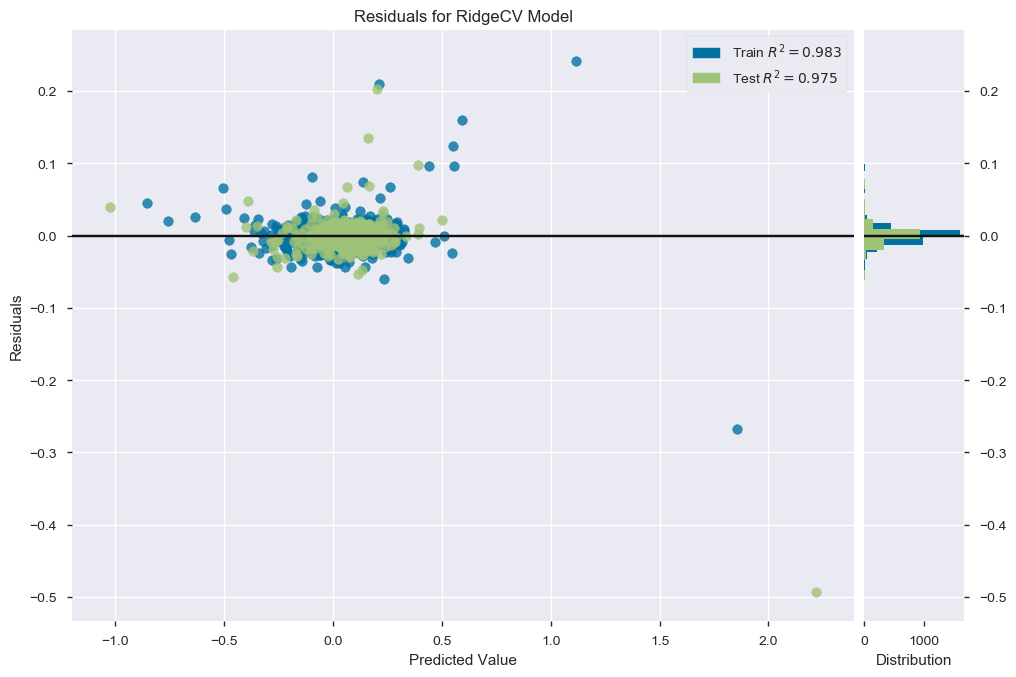

In [31]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_cv, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

# _ASSESSMENT: RIDGE REGRESSION_

### Cross-Validated Model

What gives? I split my data so why do we have to go a step further with cross-validation? 

Splitting data is always a good first step however model performance can be influenced by the way the data was split. An easy example to understand would if you were creating a model that was trying to predict sales for each day of the week. Now, what if by arbitrarily splitting the data into just a training and test, you included mostly weekends in the test set while the training data mainly was weekdays? Most of the time, buying patterns are different on weekdays versus weekends. By training a model on just weekdays, it is going to perform poorly on the test set primarily comprised of weekend observations. In summary, the model cannot be generalized to any day of the week, only weekdays! 

To avoid this, we use cross-validation. How it works is by further splitting the data into K-folds (with k being defined by you). Five and ten are probably the two most common values used for K. For example, if we are doing 5-fold cross-validation, we split the data into five folds, or subsets, of the original data. The first fold would be held out as a test data set, and then the model would be trained on the remaining four folds, representing the training data, and then we predict using that first fold and calculate our chosen performance metric (which is RMSE and R-squared in our case). After that, we would take the second fold as the test set and use fold one, three, four, and five as the training data. This process continues until each of the five folds has been used as the test data set. 

One thing we must remember though is that the more folds we create, the more computationally expensive it's going to get!

When we look above, we can see that the R-squared values are nearly identical when compared to our original baseline model. Now, why would we cross-validate if the performance of the model is the same? It's a preventative measure against overfitting. If there is one concept I want to get across is that we want to avoid overfitting at all costs to produce a model that can be applied to new, unseen data and produce reliable results. While it may not have been necessary in this instance, we don't know this until we use cross-validation which makes it an essential practice when producing machine learning models. 

# _Ridge Regression: Tuning Alpha_

In [32]:
# function to plot cross-validated R squared scores and standard error for varying different 
# alphas

# import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show(); 

In [33]:
ridge = Ridge(random_state=1)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-10, 10, 200)
ridge_scores = []
ridge_scores_std = []

In [34]:
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 5-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

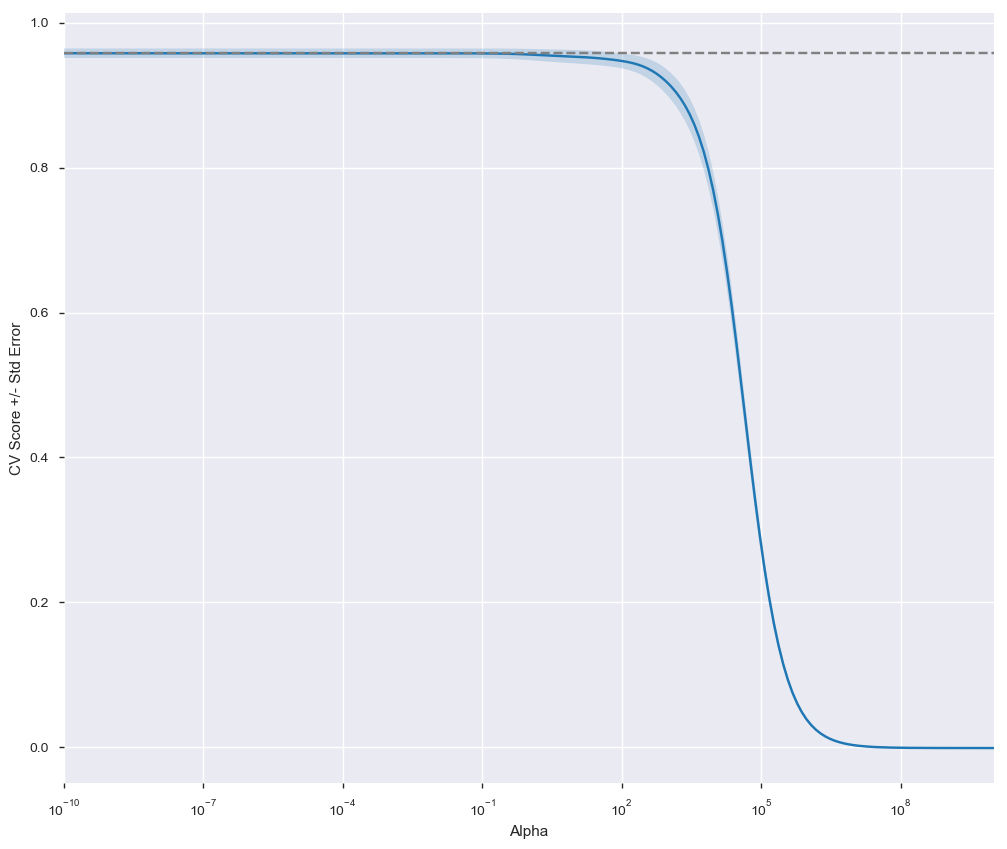

In [35]:
# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### Assessing Alpha

As we can see from the graph above, alpha holds steady at an R-squared value of approximately ~0.97 until we reach an alpha of 0.1 at which point it begins to drop. This graph indicates that 0.1 is most likely the value of alpha we want to use. 

We'll confirm this with `GridSearchCV`. This function not only does cross-validation (as indicated by CV) but also searches different values of a parameter to generate a model with the best performance. While `GridSearchCV` can handle multiple parameters, we're only going to input one which in our case is `alpha`. 

In [36]:
# Setup the hyperparameter grid
alpha_space = np.logspace(-10, 10, 200)
param_grid = {'alpha': alpha_space}

In [37]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

ridge = Ridge(random_state=1)

ridge_regressor = GridSearchCV(ridge, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv = 5)
# fit model
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-10, 1.26038e-10, ..., 7.93410e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
# predict on the hold out set and compute metrics
evaluate(ridge_regressor, X_test, y_test);

Model Performance
Root Mean Squared Error: 0.0173
R^2 Score = 0.9751


In [39]:
print(ridge_regressor.best_params_['alpha'])
print(ridge_regressor.best_score_)

1e-10
-0.00040432290795273566


In [40]:
# Create a ridge regressor with best alpha from GridSearch
ridge_alpha = Ridge(alpha = ridge_regressor.best_params_['alpha'], random_state = 1)

# fit the model on training data
ridge_alpha.fit(X_train, y_train)

# Predict on the hold out set and compute metrics
evaluate(ridge_alpha, X_test, y_test);

Model Performance
Root Mean Squared Error: 0.0173
R^2 Score = 0.9751


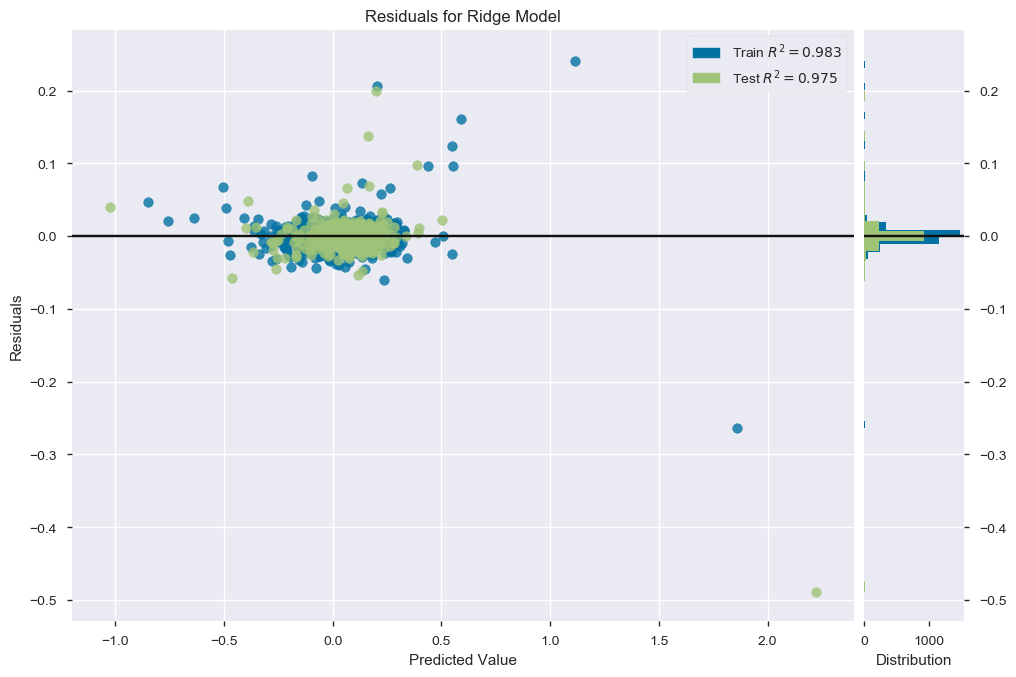

In [41]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_alpha, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

# _ASSESSMENT: RIDGE REGRESSION_

### Model with tuned Alpha

Despite confirming through `GridSearchCV` that the best value for `alpha` is 0.1, there was no improvement in the performance of the model. At this point, I feel pretty confident in this model. 

We've used cross-validation and tuned `alpha`, our lone hyperparameter, and from the looks of it have reached a ceiling in regards to the performance of the model. When we look at the R-squared scores, this model appears to do exceptionally well with a training score of 0.983 and a test score of 0.975 which is a good indicator that we haven't overfit the model since there was minimal drop-off between the two values. 

Before we move into the `Random Forest` algorithm, there is one thing I want to highlight, and that is the two pretty significant outliers, one with a residual of ~-0.27 and the other with a residual of nearly -0.5! Due to their magnitude, they are probably having a significant effect on both the RMSE and R-squared scores. I guess that these outlier predictions are the result of two outlier observations from the original data set. Despite using the `PER` statistical threshold when we processed the data, it looks like a few outliers nonetheless snuck through. 

 I still feel very confident in this model. Achieving a low RMSE and high R-squared (despite these outliers), and maintaining these values after cross-validating and tuning for alpha, I believe gives further proof that this model is more than adequate at predicting `WS/48`.

# Random Forest Regressor

The Random Forest algorithm is probably one of the most widely applicable machine learning models in use today according to Jeremy Howard, who is a top expert on machine learning and artificial intelligence. 

Before I go further though I must first talk about decision trees. Let's begin by taking a look at the picture below:

![simply tree](pictures/simple_tree.png)

_Original picture found [here](https://becominghuman.ai/understanding-decision-trees-43032111380f)_.

You begin by asking yourself the question 'am I hungry?' to which you can either respond with a yes or no. At this point you to either go to sleep or ask yourself a follow-up question: do you have 25 dollars? Now if you have 25 dollars, then you can go to a restaurant, but if you don't have that much money, then you buy a hamburger. 

In terms of a decision tree, the questions represent the tree's `Nodes`, the 'Yes/No' options represent `Edges`, and the resulting actions are the `Leafs` of the tree. 

The goal of a decision tree is as follows: "to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features" [(scikit-learn)](https://scikit-learn.org/stable/modules/tree.html). Essentially what a decision tree does is take a question and break it down into its parts until you arrive at an answer. 

Decision Trees are simple to understand, require little data preparation and can handle both numerical and categorical data. However, there are some downsides. Decision Trees can have a tendency to overfit and also be unstable which means even with small variations in the data an utterly different tree is created leading to completely different results. 

How do we get the benefits of Decision Trees while minimizing their downsides? By using a bunch of them, with a method called Random Forests. 

Below is `scikit-learn`'s description of how Random Forests work:

"In random forests (see [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) and [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model." [(scikit-learn)](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In summary, multiple samples of the training data set are taken, and a unique tree is created based on each sample. Each of these trees uses a random subset of features of which it searches for the best feature amongst them. Then these multiple decision trees are merged to produce a more accurate and stable prediction as opposed to a single decision tree alone. 

There are three important hyperparameters that we can use to increase the performance of the model. They are `n_estimators`, `max_features`, and `min_sample_leaf`.

- `n_estimators`: number of (decision) trees in the forest
- `max_features`: number of features to consider when looking for the best split
- `min_sample_leaf`: minimum number of samples required to be at a leaf node

We'll tune for these a little bit later but first, let's prepare our dataset for the `RandomForestRegressor` and create a baseline model!

In [42]:
from sklearn.ensemble import RandomForestRegressor

# convert features for random forest
X_rf, y_rf, rf_features = convert_features(df_rf, True)

# scale then split random forest data
X_train_forest, X_test_forest, y_train_forest, y_test_forest = scale_then_split(X_rf, y_rf)

(4759, 104)
(4759,)
Training Features Shape: (3331, 104)
Training Label Shape: (3331,)
Testing Features Shape: (1428, 104)
Testing Labels Shape: (1428,)


In [43]:
# Establish model
random_forest = RandomForestRegressor(n_jobs=-1, random_state = 1)

In [45]:
# fit the model on training data
random_forest.fit(X_train_forest, y_train_forest)

# Predict on the hold out set and compute metrics
predictions, rmse, r2 = evaluate(random_forest, X_test_forest, y_test_forest)

Model Performance
Root Mean Squared Error: 0.0374
R^2 Score = 0.8836


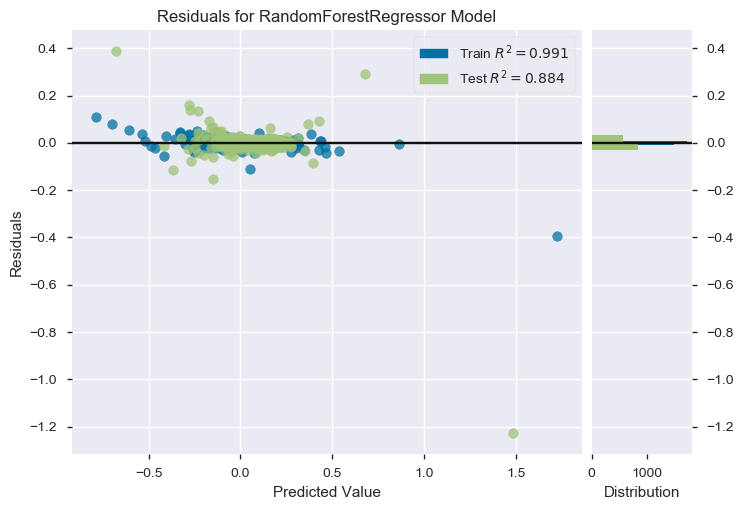

In [46]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(random_forest)

visualizer.fit(X_train_forest, y_train_forest)  # Fit the training data to the model
visualizer.score(X_test_forest, y_test_forest)  # Evaluate the model on the test data
visualizer.poof()                               # Draw/show/poof the data

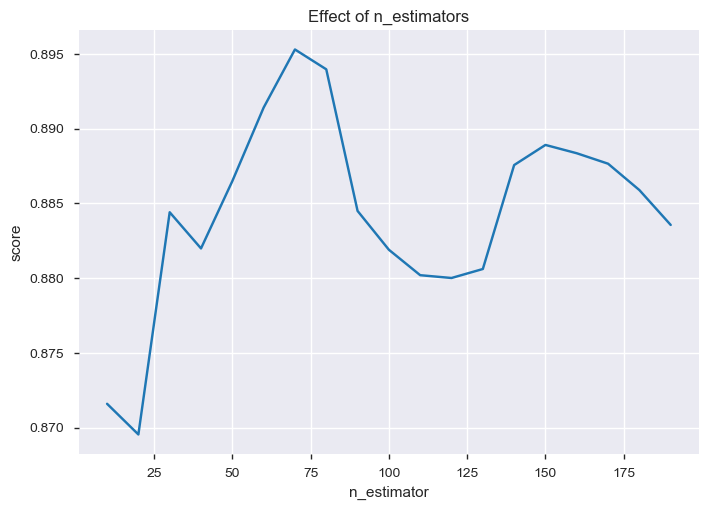

In [44]:
# try different number of n_estimators
estimators = np.arange(10, 200, 10)
scores = []

for n in estimators:
    random_forest.set_params(n_estimators = n)
    random_forest.fit(X_train_forest, y_train_forest)
    scores.append(random_forest.score(X_test_forest, y_test_forest))
    
plt.title('Effect of n_estimators')
plt.xlabel('n_estimator')
plt.ylabel('score')
plt.plot(estimators, scores);

### Effect of `n_estimators`

Remember that `n_estimators` is the total number of (decision) trees we have in our random forest. As we can see from the graph above -- which shows the relationship between the number of trees and the R-squared value of the associated model -- the performance of the model increases rather sharply from ten trees to approximately 75 trees where it achieves its highest score. 

After that, though it looks like performance gets somewhat unstable (a valley followed by another peak) as we increase the trees. From this visualization, I would hypothesize that the appropriate value for `n_estimators` would be around 75. So now let's tune our Random Forest model to see if we can't make it a little bit better!

In [64]:
# Establish model with n_estimators = 75
rf_estimator_model = RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state = 1)

In [65]:
# fit the model on training data
rf_estimator_model.fit(X_train_forest, y_train_forest)

# Predict on the hold out set and compute metrics
predictions, rmse, r2 = evaluate(rf_estimator_model, X_test_forest, y_test_forest)

Model Performance
Root Mean Squared Error: 0.0358
R^2 Score = 0.8937


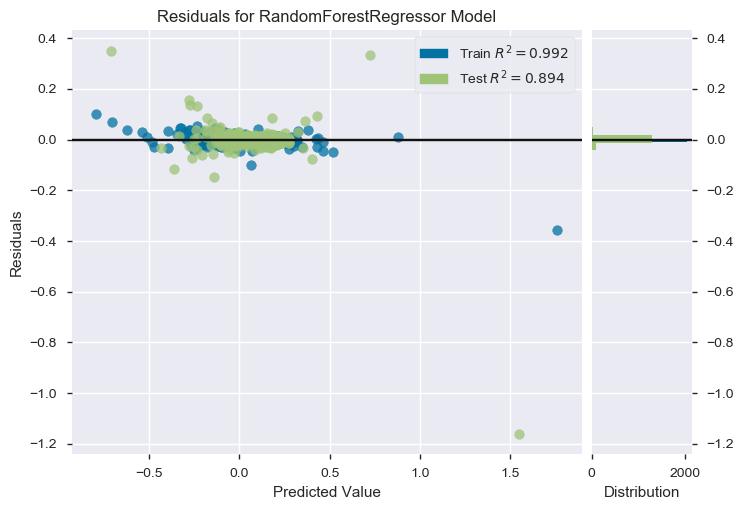

In [67]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(rf_estimator_model)

visualizer.fit(X_train_forest, y_train_forest)  # Fit the training data to the model
visualizer.score(X_test_forest, y_test_forest)  # Evaluate the model on the test data
visualizer.poof()                               # Draw/show/poof the data

## Tuning Random Forest Model

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, random_state = 1)

from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [48]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# max number of levels in trees
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# min number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create random grid
random_grid = {'n_estimators': n_estimators, #number of trees in the forest
               'max_features': max_features, # number of features to consider when looking for the best split
               'max_depth': max_depth, # max depth of the tree
               'min_samples_split': min_samples_split, # min number of samples required to split an internal node
               'min_samples_leaf': min_samples_leaf # # min number of samples required to be at a leaf node
              }

pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}


## Hyperparameters in Random Forest

We will tune our model through the following parameters:

- `n_estimators` = number of trees in the forest
- `max_features` = max number of features considered for splitting a node
- `max_depth` = max number of levels in each decision tree
- `min_samples_split` = min number of data points placed in a node before the node is split
- `min_samples_leaf` = min number of data points allowed in a leaf node

Now we could use `GridSearchCV` to explore the above space of parameters. However, since there are quite a few combinations, this would be computationally expensive and as a result, would take quite a bit of time. 

This is where `RandomizedSearchCV` comes in. It explores the same space that `GridSearchCV` but does not try all possible parameter values. Instead, it randomly selects a specified number of combinations to train and score the model. Because it is not as exhaustive, there is a slight dip in performance with `RandomizedSearchCV` but the tradeoff in time it takes to find the best parameters is usually well worth it. 

In [49]:
# create base model to tune
rf = RandomForestRegressor(n_jobs=-1, random_state = 1)

# random search of parameters, using 5 fold cv, search across 100 different combinations and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter = 100, cv = 5, 
                              verbose = 1)

# fit random search model
rf_random.fit(X_train_forest, y_train_forest);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.5min finished


In [50]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100}

In [51]:
# run random forest regression according to best parameters from RandomSearchCV
best_random = rf_random.best_estimator_
best_random.fit(X_train_forest, y_train_forest)
random_accuracy = evaluate(best_random, X_test_forest, y_test_forest)

Model Performance
Root Mean Squared Error: 0.0378
R^2 Score = 0.8810


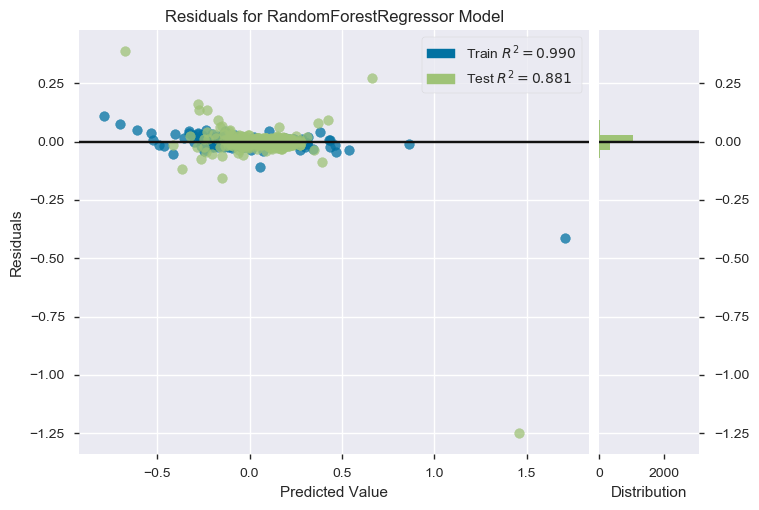

In [52]:
visualizer_best = ResidualsPlot(best_random)

visualizer_best.fit(X_train_forest, y_train_forest)  # Fit the training data to the model
visualizer_best.score(X_test_forest, y_test_forest)  # Evaluate the model on the test data
visualizer_best.poof()  

# Huber Regressor

In [53]:
from sklearn.linear_model import HuberRegressor

# run base huber regression model
huber = HuberRegressor()
huber.fit(X_train, y_train)
huber_accuracy = evaluate(huber, X_test, y_test)

Model Performance
Root Mean Squared Error: 0.0220
R^2 Score = 0.9597


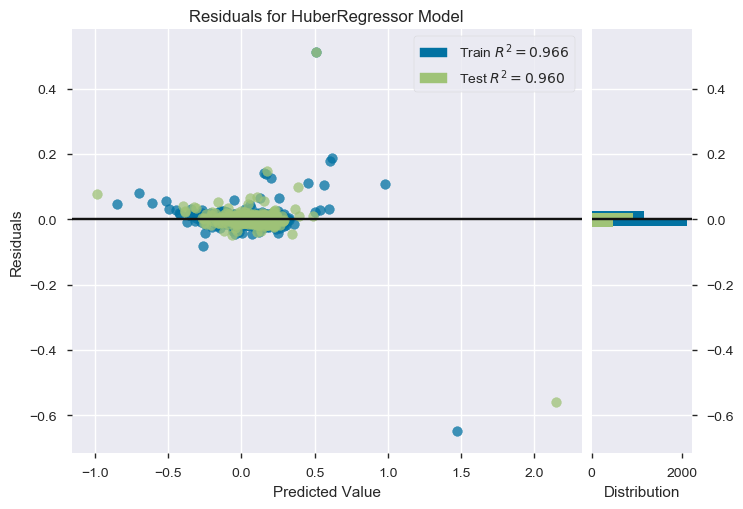

In [54]:
visualizer_huber = ResidualsPlot(huber)

visualizer_huber.fit(X_train, y_train)  # Fit the training data to the model
visualizer_huber.score(X_test, y_test)  # Evaluate the model on the test data
visualizer_huber.poof()  

# _Threshold Data: Assessing Models on New Data_

In [55]:
# one-hot encode the data for random forest model using pandas get_dummies
df_threshold = pd.get_dummies(df_threshold, columns = ['Pos', 'Tm', 'Year'])

In [56]:
# convert features for threshold
X_thres, y_thres, thres_features = convert_features(df_threshold, True)

# scale then split threshold data
X_train_th, X_test_th, y_train_th, y_test_th = scale_then_split(X_thres, y_thres)

(2526, 105)
(2526,)
Training Features Shape: (1768, 105)
Training Label Shape: (1768,)
Testing Features Shape: (758, 105)
Testing Labels Shape: (758,)


In [57]:
# run base random forest regression model
base_model = RandomForestRegressor(n_estimators=10, random_state = 1)
base_model.fit(X_train_th, y_train_th)
base_accuracy = evaluate(base_model, X_test_th, y_test_th)

Model Performance
Root Mean Squared Error: 0.0079
R^2 Score = 0.9768


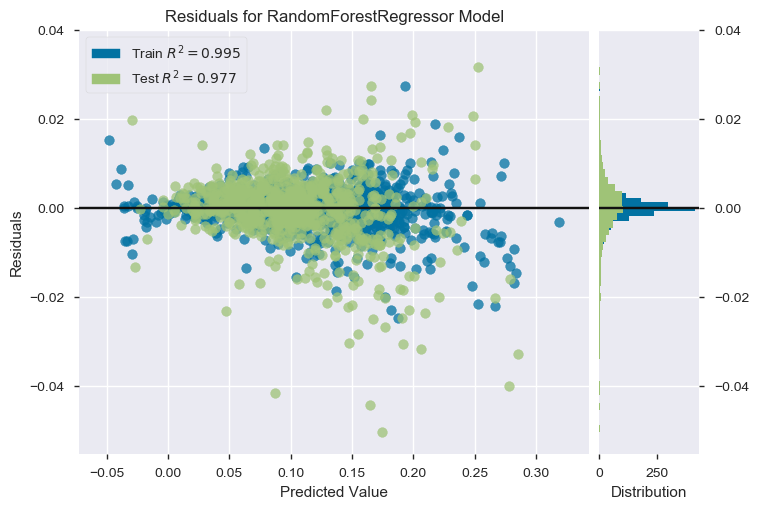

In [58]:
visualizer_base = ResidualsPlot(base_model)

visualizer_base.fit(X_train_th, y_train_th)  # Fit the training data to the model
visualizer_base.score(X_test_th, y_test_th)  # Evaluate the model on the test data
visualizer_base.poof()                 # Draw/show/poof the data

In [59]:
# run random forest regression according to best parameters from RandomSearchCV
best_random = rf_random.best_estimator_
best_random.fit(X_train_th, y_train_th)
random_accuracy = evaluate(best_random, X_test_th, y_test_th)

Model Performance
Root Mean Squared Error: 0.0066
R^2 Score = 0.9839


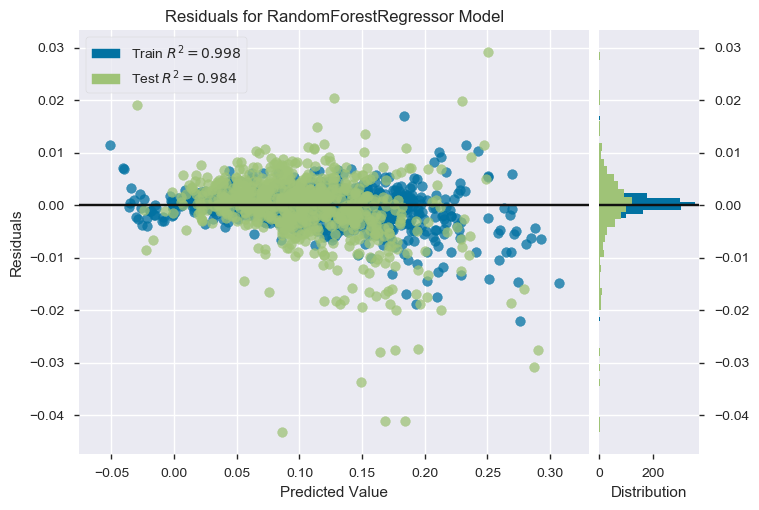

In [60]:
visualizer_best = ResidualsPlot(best_random)

visualizer_best.fit(X_train_th, y_train_th)  # Fit the training data to the model
visualizer_best.score(X_test_th, y_test_th)  # Evaluate the model on the test data
visualizer_best.poof()  

### Ridge Regression on New Data

In [71]:
# dataframe that sets cut-off based on PER (i.e. player played more than 58 games)
df_threshold = pd.read_csv('data/df_threshold-Copy1.csv')

df_threshold[['Pos', 'Tm', 'Year']] = df_threshold[['Pos', 'Tm', 'Year']].astype('category')

In [72]:
# create array of features and target variable for regression model
X_thres, y_thres, features_thres = convert_features(df, random_forest=False)

(4759, 42)
(4759,)


In [73]:
# scale then split data
X_train_th, X_test_th, y_train_th, y_test_th = scale_then_split(X_thres, y_thres)

Training Features Shape: (3331, 42)
Training Label Shape: (3331,)
Testing Features Shape: (1428, 42)
Testing Labels Shape: (1428,)


In [74]:
# Create a ridge regressor
ridgecv_th = RidgeCV(cv = 5)

In [75]:
# fit the model on training data
ridgecv_th.fit(X_train_th, y_train_th)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [76]:
# predict on the hold out set and compute metrics
evaluate(ridgecv_th, X_test_th, y_test_th);

Model Performance
Root Mean Squared Error: 0.0174
R^2 Score = 0.9749


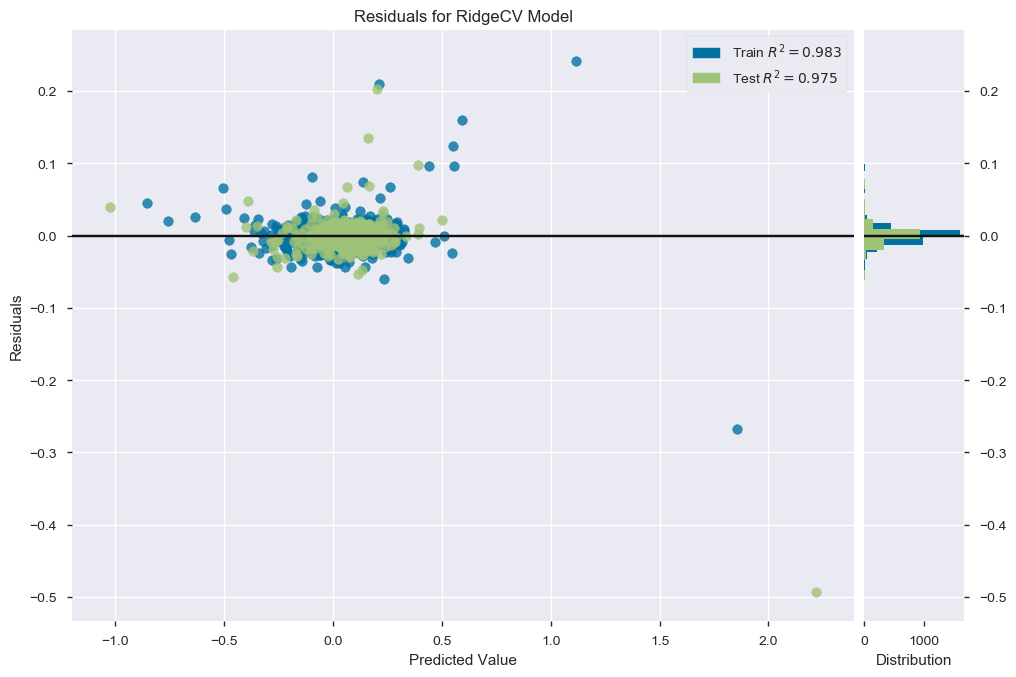

In [78]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridgecv_th, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train_th, y_train_th)  # Fit the training data to the model
visualizer.score(X_test_th, y_test_th)  # Evaluate the model on the test data
visualizer.poof();  